# Import Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import pathlib
from PIL import Image

# Functions

# Data Loading + Pre-Processing

In [2]:
data_dir = r"C:\Users\faiza\Documents\Uni\Year 3\Final Project\Code\images"

In [3]:
data_dir = pathlib.Path(data_dir).with_suffix('')

In [4]:
data_dir

WindowsPath('C:/Users/faiza/Documents/Uni/Year 3/Final Project/Code/images')

In [5]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

35887


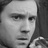

In [6]:
angry = list(data_dir.glob('angry/*'))
PIL.Image.open(str(angry[0]))

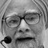

In [7]:
PIL.Image.open(str(angry[1]))

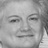

In [8]:
happy = list(data_dir.glob('happy/*'))
PIL.Image.open(str(happy[0]))

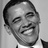

In [9]:
PIL.Image.open(str(happy[1]))

# Loading Data

In [10]:
# batch size refers to the number of training examples utilised in one iteration. It will process 32 images at a time during training
batch_size = 32
#the height of the images will be restricted to 180
img_height = 180
#the width of the images will be restricted to 180
img_width = 180

In [11]:
#begins the creation of the training dataset using tensorflow's keras api
#image_dataset_from_directory is used to load and preprocess the images so that it is suitable to train a model
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2, #80% of the data will be trained and 20% will be used to test it
    subset="training", #this specifies that it is for training
    seed=123, #random number generator to shuffle the dataset and create the split
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 35887 files belonging to 7 classes.
Using 28710 files for training.


In [12]:
#begins the creation of the validation dataset using tensorflow's keras api
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation", #this specifies that it is for validation
    seed=123, #this is the same to keep the split the same
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 35887 files belonging to 7 classes.
Using 7177 files for validation.


In [13]:
#gets the class names
class_names = train_ds.class_names
print(class_names)

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


# Visualise Data

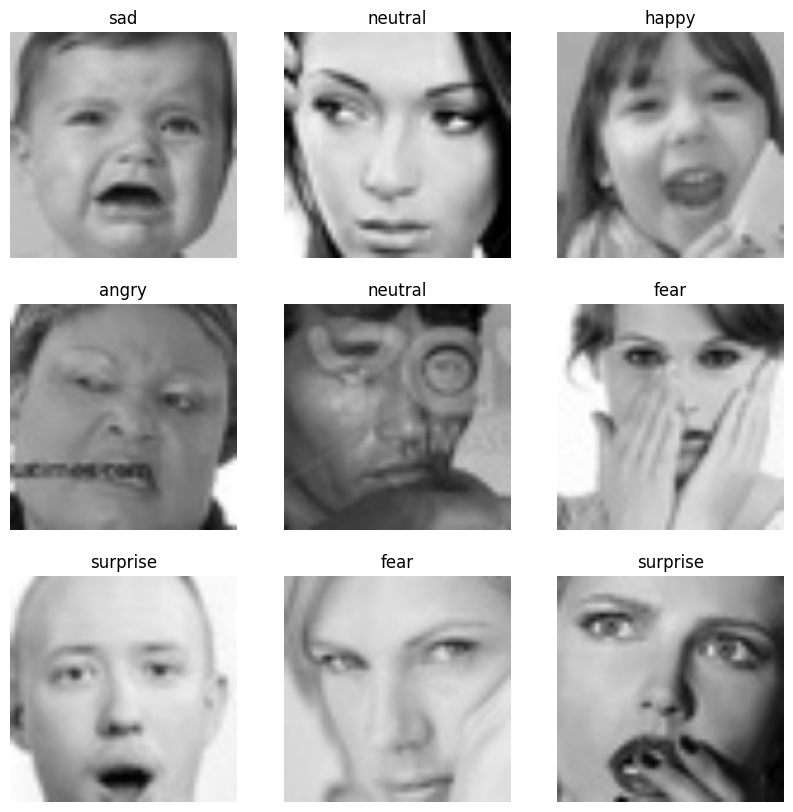

In [14]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [15]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


# Data Configuration

In [16]:
#this optimises the performance of the training and validation datasets
#tf.data.AUTOTUNE prompts tensorflow to tune the buffering of elements in the data pipeline for optimal performance
#by setting it as a variable, it is being prepared to be used in the dataset operations that follow, allowing TensorFlow
#to dynamically adjust how much data to prefetch based on the current system's available resources
AUTOTUNE = tf.data.AUTOTUNE
#caches elements of train_ds. this loads images and labels into memory during the first epoch (iteration over dataset)
#this ensures them being reused in in subsequent epochs, speeding the training as I/O is reduced
#prefetch(buffer_size=AUTOTUNE) - prefetches the data; this is whilst the model is executing step 's' the input pipeline
#is reading step 's+1'
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [17]:
#creates a normalisation layer 1/255 is the factor each pixel will be multiplied. converts [0,255] to [0,1]
normalization_layer = layers.Rescaling(1./255)

In [18]:
#maps the values [0,255] to [0,1]. that only applies to the x values and not the y values
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.109777786 0.9171243


# Creating Model (Keras)

In [19]:
num_classes = len(class_names)
#Squential is a linear stack of layers which is one of the most simplest types of models in Keras. layers are just
#stacked in sequence
model = Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)), #the first layer; reschales layer to normalise the pixel values of the input image
    layers.Conv2D(16, 3, padding='same', activation='relu'), #a 2D convolutional layer with 16 filters of size 3x3; RELU activation + padding='same'
    #means the output size will be the same as the input
    layers.MaxPooling2D(), #a max pooling layer reduces spatial dimensions of the input volume; helps with reducing the no. of parameters and computation
    layers.Conv2D(32, 3, padding='same', activation='relu'), #the depth of filters is increased
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(), #flattens the 3D output into a 1D array. this is because it will be used as the input to dense layers (which expect 1D arrays)
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

# Compile the Model

In [20]:
#adam optimiser used. it is a popular choice for optimisation
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Model Summary

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

# Train Model

In [22]:
epochs=40
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/40
898/898 [==============================] - 288s 319ms/step - loss: 1.6161 - accuracy: 0.3619 - val_loss: 1.4794 - val_accuracy: 0.4324
Epoch 2/40
898/898 [==============================] - 284s 316ms/step - loss: 1.3387 - accuracy: 0.4863 - val_loss: 1.3485 - val_accuracy: 0.4843
Epoch 3/40
898/898 [==============================] - 288s 321ms/step - loss: 1.1450 - accuracy: 0.5684 - val_loss: 1.3351 - val_accuracy: 0.5008
Epoch 4/40
898/898 [==============================] - 282s 314ms/step - loss: 0.9165 - accuracy: 0.6607 - val_loss: 1.4405 - val_accuracy: 0.5022
Epoch 5/40
898/898 [==============================] - 288s 321ms/step - loss: 0.6536 - accuracy: 0.7648 - val_loss: 1.6975 - val_accuracy: 0.4997
Epoch 6/40
898/898 [==============================] - 283s 315ms/step - loss: 0.4080 - accuracy: 0.8565 - val_loss: 2.1004 - val_accuracy: 0.4988
Epoch 7/40
898/898 [==============================] - 283s 315ms/step - loss: 0.2420 - accuracy: 0.9188 - val_loss: 2.7607 -

# Visualise Training Results

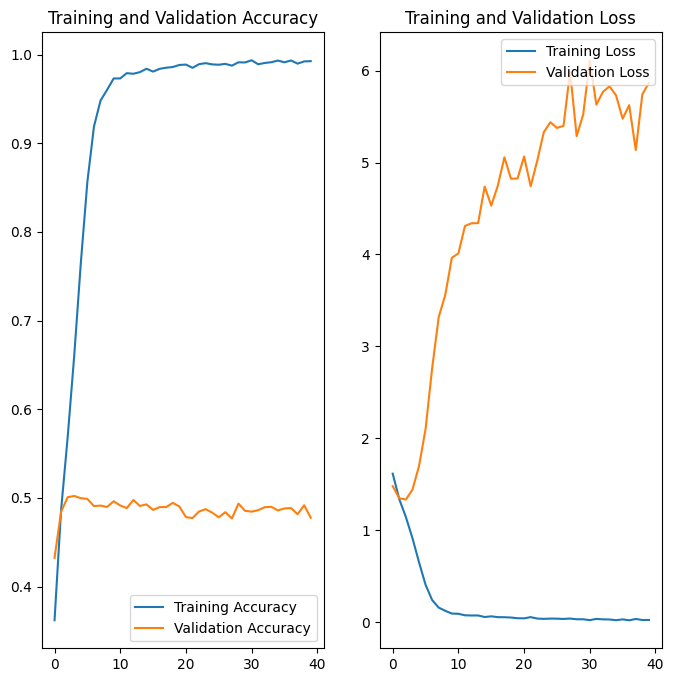

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Data Augmentation

In [24]:
#Applies random transformations to the data. This improves the generalisation of the model and reduces overfitting
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal", #flips horizontally (left to right)
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1), #randomly rotates the images by a random degree within the range [-10% * 2π, 10% * 2π]
    layers.RandomZoom(0.1), #it randomly zooms the images in and out by 10%
  ]
)

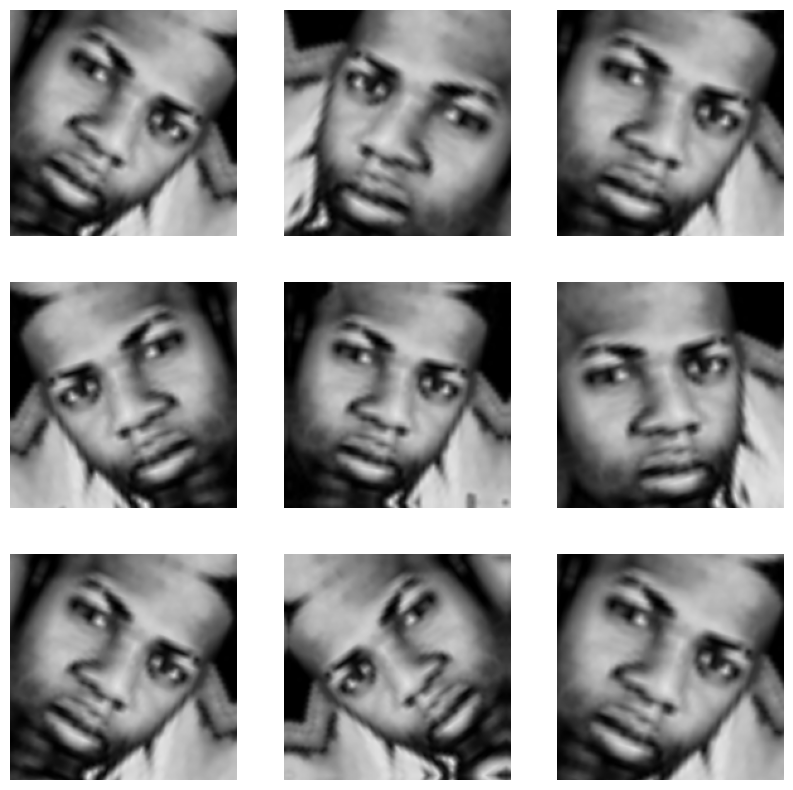

In [25]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

# Dropout

In [26]:
model = Sequential([
  data_augmentation, # will apply what happened in data augmentation from before
  layers.Rescaling(1./255), #normalises data after augmentation. scales the pixels to [0, 1]
  layers.Conv2D(16, 3, padding='same', activation='relu'), #convolutional and pooling layers are added for feature extraction
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2), #a dropout layer is added which converts 2D feature maps to a 1D feature vector, allowing it to be fed into the dense layers
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

# Compile Model

In [27]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [28]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 90, 90, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                 

In [29]:
epochs = 60
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/60


898/898 [==============================] - 324s 359ms/step - loss: 1.7789 - accuracy: 0.2691 - val_loss: 1.7177 - val_accuracy: 0.3024
Epoch 2/60
898/898 [==============================] - 319s 356ms/step - loss: 1.7049 - accuracy: 0.3056 - val_loss: 1.6148 - val_accuracy: 0.3644
Epoch 3/60
898/898 [==============================] - 321s 358ms/step - loss: 1.5872 - accuracy: 0.3747 - val_loss: 1.4901 - val_accuracy: 0.4244
Epoch 4/60
898/898 [==============================] - 323s 359ms/step - loss: 1.5076 - accuracy: 0.4118 - val_loss: 1.4357 - val_accuracy: 0.4487
Epoch 5/60
898/898 [==============================] - 319s 355ms/step - loss: 1.4565 - accuracy: 0.4345 - val_loss: 1.4577 - val_accuracy: 0.4400
Epoch 6/60
898/898 [==============================] - 323s 360ms/step - loss: 1.4229 - accuracy: 0.4501 - val_loss: 1.3867 - val_accuracy: 0.4677
Epoch 7/60
898/898 [==============================] - 327s 364ms/step - loss: 1.3988 - accuracy: 0.4612 - val_loss: 1.3669 - val_accura

# Visualise Training Results

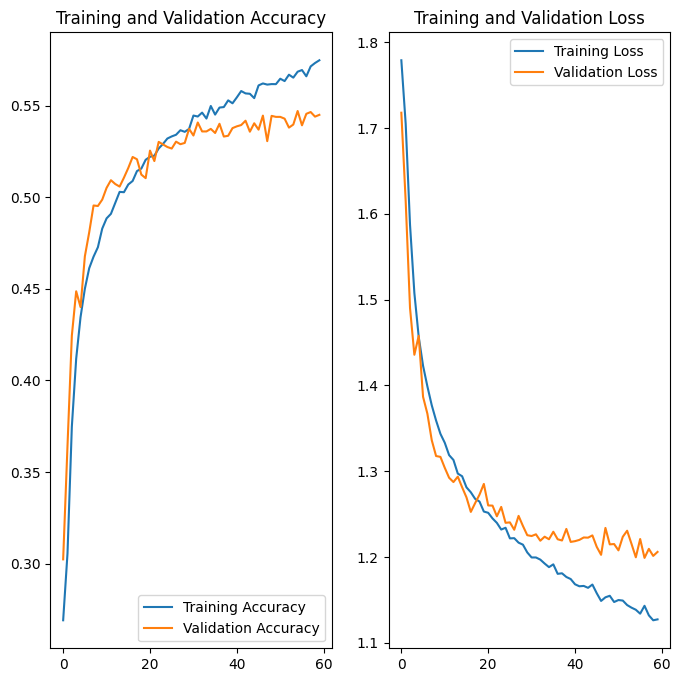

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Predict on New Data

In [84]:
pic_path = r"C:\Users\faiza\Downloads\WhatsApp Image 2024-02-15 at 10.53.10_5587b68b1.jpg"

img = tf.keras.utils.load_img(
    pic_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 24ms/step
This image most likely belongs to angry with a 39.13 percent confidence.


# Tensorflow Lite

## Tensorflow Keras Sequential Model to Tensorflow Lite Model

In [32]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\faiza\AppData\Local\Temp\tmpf4s2mt2a\assets


INFO:tensorflow:Assets written to: C:\Users\faiza\AppData\Local\Temp\tmpf4s2mt2a\assets


In [33]:
TF_MODEL_FILE_PATH = 'model.tflite' # The default path to the saved TensorFlow Lite model

interpreter = tf.lite.Interpreter(model_path=TF_MODEL_FILE_PATH)

In [34]:
interpreter.allocate_tensors()

In [35]:
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [36]:
input_shape = input_details[0]['shape']
input_dtype = input_details[0]['dtype']

In [71]:
image_path = r"C:\Users\faiza\Downloads\WhatsApp Image 2024-02-15 at 10.53.10_5587b68b1.jpg"

In [72]:
img = Image.open(image_path).resize((input_shape[1], input_shape[2]))
img_array = np.array(img)

In [73]:
img_array = img_array / 255.0

In [74]:
if img_array.ndim == 2:
    img_array = np.stack((img_array,) * 3, axis=-1)
elif img_array.shape[2] == 4:
    img_array = img_array[..., :3]

In [75]:
img_array = np.expand_dims(img_array, axis=0).astype(input_dtype)

In [76]:
interpreter.set_tensor(input_details[0]['index'], img_array)

In [77]:
interpreter.invoke()

In [78]:
output_data = interpreter.get_tensor(output_details[0]['index'])

In [79]:
predicted_class = np.argmax(output_data, axis=1)
print(f"Predicted Class: {predicted_class}")

Predicted Class: [0]


In [80]:
# Assuming output_data is the output from your TFLite model
score_lite = tf.nn.softmax(output_data).numpy()
score_lite

array([[5.6043267e-01, 5.3308280e-10, 2.3010762e-02, 1.2683167e-01,
        2.5074029e-01, 3.0745555e-02, 8.2390914e-03]], dtype=float32)

In [81]:
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score_lite)], 100 * np.max(score_lite))
)

This image most likely belongs to angry with a 56.04 percent confidence.
